In [1]:
import mplfinance as mpf
import matplotlib as mpl# 用于设置曲线参数
from cycler import cycler# 用于定制线条颜色
import pandas as pd# 导入DataFrame数据
import matplotlib.pyplot as plt
import numpy as np
import baostock as bs

def plotCandle(data,code):   
    # 设置基本参数
    # type:绘制图形的类型，有candle, renko, ohlc, line等
    # 此处选择candle,即K线图
    # mav(moving average):均线类型,此处设置7,30,60日线
    # volume:布尔类型，设置是否显示成交量，默认False
    # title:设置标题
    # y_label:设置纵轴主标题
    # y_label_lower:设置成交量图一栏的标题
    # figratio:设置图形纵横比
    # figscale:设置图形尺寸(数值越大图像质量越高)
    kwargs = dict(
        type='candle', 
        mav=(7, 30,60), 
        volume=True, 
        title='\nA_stock %s candle_line' % (code),    
        ylabel='OHLC Candles', 
        ylabel_lower='Shares\nTraded Volume', 
        figratio=(15, 10), 
        figscale=10)
    
    # 设置marketcolors
    # up:设置K线线柱颜色，up意为收盘价大于等于开盘价
    # down:与up相反，这样设置与国内K线颜色标准相符
    # edge:K线线柱边缘颜色(i代表继承自up和down的颜色)，下同。详见官方文档)
    # wick:灯芯(上下影线)颜色
    # volume:成交量直方图的颜色
    # inherit:是否继承，选填
    mc = mpf.make_marketcolors(
        up='red', 
        down='green', 
        edge='i', 
        wick='i', 
        volume='in', 
        inherit=True)

    # 设置图形风格
    # gridaxis:设置网格线位置
    # gridstyle:设置网格线线型
    # y_on_right:设置y轴位置是否在右
    s = mpf.make_mpf_style(
        gridaxis='both', 
        gridstyle='-.', 
        y_on_right=False, 
        marketcolors=mc)

    # 设置均线颜色，配色表可见下图
    # 建议设置较深的颜色且与红色、绿色形成对比
    # 此处设置七条均线的颜色，也可应用默认设置
    mpl.rcParams['axes.prop_cycle'] = cycler(
        color=['dodgerblue', 'deeppink', 
        'navy', 'teal', 'maroon', 'darkorange', 
        'indigo'])

    # 设置线宽
    mpl.rcParams['lines.linewidth'] = .5
    
    # 图形绘制
    # show_nontrading:是否显示非交易日，默认False
    # savefig:导出图片，填写文件名及后缀
#     mpf.plot(data, 
#         **kwargs, 
#         style=s, 
#         show_nontrading=False,
#         savefig='A_stock-%s_candle_line'
#          % (code) + '.jpg')
    mpf.plot(data, 
        **kwargs, 
        style=s, 
        show_nontrading=False)
    
def getData(code,start_date,end_date):
    frequency = "d"
    item_list = "date,code,open,high,low,close,preclose,volume,amount,adjustflag,turn,tradestatus,pctChg,isST"
    rs = bs.query_history_k_data_plus(code,item_list,
                                      start_date,end_date,
                                     frequency=frequency)

    #print(",rs.error_code={},rs.error_msg={}".format(rs.error_code,rs.error_msg))

    #save data
    data_list = []
    while(rs.error_code == "0" ) and rs.next():
        data_list.append(rs.get_row_data())
    stock_data = pd.DataFrame(data_list,columns=rs.fields)
    stock_data.to_csv("./data/{}.csv".format(code))
    return stock_data

# download data from Internet
def downloadData(code,start_date,end_date):
    frequency = "d"
    item_list = "date,code,open,high,low,close,preclose,volume,amount,adjustflag,turn,tradestatus,pctChg,isST"
    rs = bs.query_history_k_data_plus(code,item_list,
                                      start_date,end_date,
                                     frequency=frequency)

    #print(",rs.error_code={},rs.error_msg={}".format(rs.error_code,rs.error_msg))

    #save data
    data_list = []
    while(rs.error_code == "0" ) and rs.next():
        data_list.append(rs.get_row_data())
    stock_data = pd.DataFrame(data_list,columns=rs.fields)
    #stock_data.to_csv("./data/{}.csv".format(code))
    return stock_data
    
#把数据处理成k线图的数据结构
def dataProcess(data):
    #data = pd.read_csv(csvfile)
    daily = {}
    daily["Date"] = data["date"]
    daily["Open"] = data["open"]
    daily["High"] = data["high"]
    daily["Low"] = data["low"]
    daily["Close"] = data["close"]
    daily["Volume"] = data["volume"]

    d = pd.DataFrame(daily)
    d['Date'] = pd.to_datetime(daily['Date'])
    d.set_index(['Date'],inplace=True)
    return d

def readData(csvfile):
    data = pd.read_csv(csvfile)
    daily = {}
    daily["Date"] = data["date"]
    daily["Open"] = data["open"]
    daily["High"] = data["high"]
    daily["Low"] = data["low"]
    daily["Close"] = data["close"]
    daily["Volume"] = data["volume"]

    d = pd.DataFrame(daily)
    d['Date'] = pd.to_datetime(daily['Date'])
    d.set_index(['Date'],inplace=True)
    return d


#连续三天收盘价增高或者降低，就添加趋势翻转标记
def myMomentDot(d):
    fig = plt.figure(0,figsize=(10,10))
    date = []
    close_p = []
    open_p = []#今日开盘价
    flg_l = []
    flg = 0
    for i in range(4,len(d["Close"])):
        moment = 0
        for j in range(3):
            if d["Close"][i-j-1] > d["Close"][i-j-2]:
                moment += 1
        if moment == 3:
            flg = 1
            flg_l.append(flg)
            close_p.append(d["Close"][i])
            open_p.append(d["Open"][i])
        elif moment == 0:
            flg = -1
            flg_l.append(flg)
            close_p.append(d["Close"][i])
            open_p.append(d["Open"][i])
            
            
        else:
            flg = 0
            flg_l.append(flg)
            close_p.append(d["Close"][i])
            open_p.append(d["Open"][i])
            
    return flg_l, close_p

#myMomentDot策略添加一个条件：当天下跌超过3%的卖出 
def myMomentDot2(d):
    fig = plt.figure(0,figsize=(10,10))
    date = []
    close_p = []
    open_p = []#今日开盘价
    flg_l = []
    flg = 0
    for i in range(4,len(d["Close"])):
        moment = 0
        for j in range(3):
            if d["Close"][i-j-1] > d["Close"][i-j-2]:
                moment += 1
        if moment == 3:
            flg = 1
            flg_l.append(flg)
            close_p.append(d["Close"][i])
            open_p.append(d["Open"][i])
        elif moment == 0 or (float(d["Open"][i-1]) - float(d["Close"][i-1]))/float(d["Open"][i-1]) > 0.03:
            flg = -1
            flg_l.append(flg)
            close_p.append(d["Close"][i])
            open_p.append(d["Open"][i])
            
        else:
            flg = 0
            flg_l.append(flg)
            close_p.append(d["Close"][i])
            open_p.append(d["Open"][i])
            
    return flg_l, close_p

def plotMyMomentDot(flg_l, close_p):
    for i in range(len(flg_l) - 3):
        if flg_l[i] == 1 :
            mark = "v"
            color = "r"
        elif flg_l[i] == -1:
            mark = "d"
            color = "g"
        elif flg_l[i] == 0:
            mark = "."
            color = "b"
        plt.scatter(i,close_p[i],marker=mark,c=color)
    plt.show()
    

def test(flg_l,close_p):
    stock_pool = 0# flag=0未持有，flag=1持有，
    pre_close = 0
    chg  = 0 #累计收益率
    chg_p = 0 #累计增长的价格
    n = 0 #交易次数
    for i in range(1,len(close_p)):
        if flg_l[i-1] == 1 and stock_pool == 0:
            open_p = d["Open"][i]
            stock_pool = 1
            n += 1
        if flg_l[i-1]==-1 and stock_pool==1:
            chg += (d["Close"][i] - open_p)/open_p - 0.003
            chg_p += d["Close"][i] - open_p 
            stock_pool = 0
            n += 1
    #print("chg = {}% ".format(chg*100))
    #print("chg_p = ",chg_p)
    return chg,chg_p,n
    
def ma(data,days:int):
    ma = [x for x in data["Close"][:days]]
    for i in range(days,len(data["Close"])):
        ma.append(sum(data["Close"][i-days:i])/days)
    return ma

In [2]:
stockNameDict = {
    "sh.600606":"烽火通讯",
    "SZ.300676":"华大基因",
    "SH.000100":"TCL科技",
    "SH.000050":"深天马A"
    
}

In [3]:
def typeTest(code:"code", num:int =2):
    print("code = {}, type(code):{}".format(code,type(code)))    
    print("num = {}, type(num):{}".format(num,type(num)))

typeTest("aaa",True)

code = aaa, type(code):<class 'str'>
num = True, type(num):<class 'bool'>


In [19]:
data["close"]

TypeError: 'module' object is not subscriptable

login success!
login respond: lg.error_code=0,lg.error_msg=success


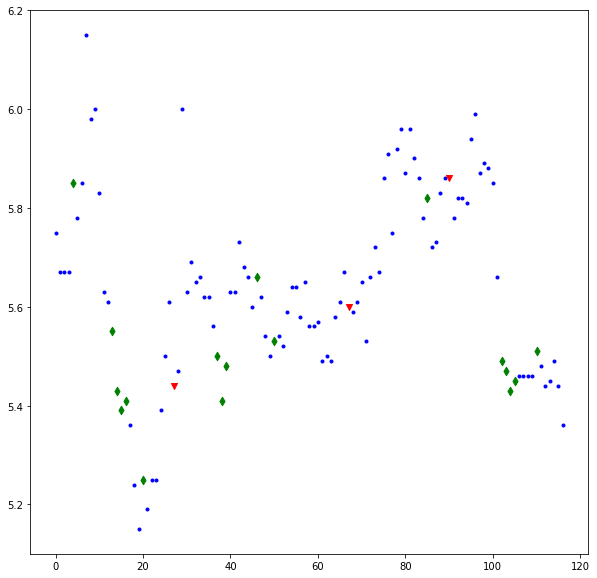

stock_code:sh.600606 , chg:15.583092635316614%, chg_p:0.9000000000000004, times:6


In [4]:
if __name__ == "__main__":
    stock_code = "sh.600606"#烽火通讯
#     stock_code = "sh.601100"
#     stock_code = "SZ.300676"#华大基因
#     stock_code = "SH.000100"#TCL科技
#     stock_code = "SH.000050"#深天马
    start_date = "2021-03-01"
    end_date = "2021-07-10"
    
    #登录baostock
    lg = bs.login()
    print("login respond: lg.error_code={},lg.error_msg={}"
      .format(lg.error_code,lg.error_msg))
    
    #data = getData(stock_code, start_date, end_date)
    #d = dataProcess(data)
    d = readData("./data/"+stock_code+".csv")
    #plotCandle(d, stock_code)
    flg_l, close_p = myMomentDot(d)
    plotMyMomentDot(flg_l, close_p)
    chg,chg_p,n = test(flg_l, close_p)
    print("stock_code:{} , chg:{}%, chg_p:{}, times:{}".format(stock_code,chg*100,chg_p,n))
    
    

In [10]:
def upMa(data):
    ma5 = ma(data,5)
    flagList = np.zeros(len(ma5))
    for i in range(5,len(ma5)-1):
        if data["close"][i] > ma5[i] and ma5[i]>ma5[i-1]:
            flagList[i+1] = 1
        elif data["close"][i] < ma5[i] and ma5[i]<ma5[i-1]:
            flagList[i+1] = -1
            
    return flagList

if __name__ == "__main__":
    stock_code = "sh.600606"#烽火通讯
#     stock_code = "sh.601100"
#     stock_code = "SZ.300676"#华大基因
#     stock_code = "SH.000100"#TCL科技
#     stock_code = "SH.000050"#深天马
    start_date = "2021-01-01"
    end_date = "2021-07-10"
    
    #登录baostock
    lg = bs.login()
    print("login respond: lg.error_code={},lg.error_msg={}"
      .format(lg.error_code,lg.error_msg))
    
    #data = getData(stock_code, start_date, end_date)
    #d = dataProcess(data)
    d = readData("./data/"+stock_code+".csv")
    #plotCandle(d, stock_code)
    flg_l, close_p = myMomentDot(d)
    #plotMyMomentDot(flg_l, close_p)
    chg,chg_p,n = test(flg_l, close_p)
    print("stock_code:{} , chg:{}%, chg_p:{}, times:{}".format(stock_code,chg*100,chg_p,n))
    
    

In [9]:
ma5 = ma(d,5)
ma5

[5.72,
 5.72,
 5.78,
 5.69,
 5.75,
 5.732,
 5.7219999999999995,
 5.712000000000001,
 5.69,
 5.7219999999999995,
 5.728,
 5.764,
 5.859999999999999,
 5.921999999999999,
 5.952,
 5.962000000000001,
 5.918,
 5.8100000000000005,
 5.724,
 5.61,
 5.522,
 5.478,
 5.428,
 5.366,
 5.31,
 5.281999999999999,
 5.238,
 5.216,
 5.218,
 5.266,
 5.316000000000001,
 5.4,
 5.438000000000001,
 5.482,
 5.604,
 5.63,
 5.646,
 5.688,
 5.726,
 5.65,
 5.648000000000001,
 5.622,
 5.5920000000000005,
 5.542,
 5.514,
 5.516,
 5.529999999999999,
 5.576,
 5.63,
 5.666,
 5.659999999999999,
 5.666,
 5.644,
 5.6160000000000005,
 5.584,
 5.57,
 5.546,
 5.526,
 5.536,
 5.564,
 5.586,
 5.593999999999999,
 5.62,
 5.613999999999999,
 5.597999999999999,
 5.584,
 5.566,
 5.536,
 5.522,
 5.526000000000001,
 5.534000000000001,
 5.57,
 5.590000000000001,
 5.61,
 5.6160000000000005,
 5.624,
 5.596000000000001,
 5.6080000000000005,
 5.634,
 5.645999999999999,
 5.688,
 5.763999999999999,
 5.782,
 5.822,
 5.88,
 5.882,
 5.892,
 5.

In [ ]:
if __name__ == "__main__":
    #stock_code = "sh.600498"#烽火通讯
    #stock_code = "sh.600660"#福耀玻璃
    start_date = "2021-01-01"
    end_date = "2021-05-19"
    
    #登录baostock
    lg = bs.login()
    print("login respond: lg.error_code={},lg.error_msg={}"
      .format(lg.error_code,lg.error_msg))
    
    # 获取沪深300成分股
    rs = bs.query_hs300_stocks()
    print('query_hs300 error_code:'+rs.error_code)
    print('query_hs300  error_msg:'+rs.error_msg)
    # 打印结果集
    hs300_stocks = []
    while (rs.error_code == '0') & rs.next():
        # 获取一条记录，将记录合并在一起
        hs300_stocks.append(rs.get_row_data())
    result = pd.DataFrame(hs300_stocks, columns=rs.fields)
    
    i=0
    for stock_code in result["code"]:
        #data = getData(stock_code, start_date, end_date)
        #d = dataProcess(data)
        d = readData("./data/"+stock_code+".csv")
        #plotCandle(d, stock_code)
        flg_l, close_p = myMomentDot(d)
        #plotMyMomentDot(flg_l, close_p)
        chg, chg_p, n = test(flg_l, close_p)
        print("stock_code:{} , chg:{}%, chg_p:{}, times:{}".format(stock_code,chg*100,chg_p,n))
        
#         i+=1
#         if i>10:
#             break
    

沪深300成分股，测试时间2016-03-04到2020-04-30（大盘没有什么明显的趋势）

In [ ]:
if __name__ == "__main__":
    #stock_code = "sh.600498"#烽火通讯
    #stock_code = "sh.600660"#福耀玻璃
    start_date = "2016-03-04"
    end_date = "2020-04-30"
    
    #登录baostock
    lg = bs.login()
    print("login respond: lg.error_code={},lg.error_msg={}"
      .format(lg.error_code,lg.error_msg))
    
    # 获取沪深300成分股
    rs = bs.query_hs300_stocks()
    print('query_hs300 error_code:'+rs.error_code)
    print('query_hs300  error_msg:'+rs.error_msg)
    # 打印结果集
    hs300_stocks = []
    while (rs.error_code == '0') & rs.next():
        # 获取一条记录，将记录合并在一起
        hs300_stocks.append(rs.get_row_data())
    result = pd.DataFrame(hs300_stocks, columns=rs.fields)
    
    i=0
    for stock_code in result["code"]:
        #data = getData(stock_code, start_date, end_date)
        #d = dataProcess(data)
        d = readData("./data/"+stock_code+".csv")
        #plotCandle(d, stock_code)
        flg_l, close_p = myMomentDot2(d)
        #plotMyMomentDot(flg_l, close_p)
        chg, chg_p, n = test(flg_l, close_p)
        print("stock_code:{} , chg:{}%, chg_p:{}, times:{}".format(stock_code,chg*100,chg_p,n))
        
#         i+=1
#         if i>10:
#             break
    

In [ ]:
if __name__ == "__main__":
    #stock_code = "sh.600498"#烽火通讯
    #stock_code = "sh.600660"#福耀玻璃
    start_date = "2016-03-04"
    end_date = "2020-04-30"
    
    #登录baostock
    lg = bs.login()
    print("login respond: lg.error_code={},lg.error_msg={}"
      .format(lg.error_code,lg.error_msg))
    
    # 获取沪深300成分股
    rs = bs.query_hs300_stocks()
    print('query_hs300 error_code:'+rs.error_code)
    print('query_hs300  error_msg:'+rs.error_msg)
    # 打印结果集
    hs300_stocks = []
    while (rs.error_code == '0') & rs.next():
        # 获取一条记录，将记录合并在一起
        hs300_stocks.append(rs.get_row_data())
    result = pd.DataFrame(hs300_stocks, columns=rs.fields)
    
    i=0
    for stock_code in result["code"]:
        
        i+=1
        if i<20 or i>50:
            continue
        
        #data = getData(stock_code, start_date, end_date)
        #d = dataProcess(data)
        d = readData("./data/"+stock_code+".csv")
        #plotCandle(d, stock_code)
        flg_l, close_p = myMomentDot(d)
        plotMyMomentDot(flg_l, close_p)
        chg, chg_p, n = test(flg_l, close_p)
        print("stock_code:{} , chg:{}%, chg_p:{}, times:{}".format(stock_code,chg*100,chg_p,n))
        

选

In [ ]:
if __name__ == "__main__":
    #stock_code = "sh.600498"#烽火通讯
    #stock_code = "sh.600660"#福耀玻璃
    start_date = "2020-07-01"
    end_date = "2020-07-7"
    
    #登录baostock
    lg = bs.login()
    print("login respond: lg.error_code={},lg.error_msg={}"
      .format(lg.error_code,lg.error_msg))
    
    # 获取沪深300成分股
    rs = bs.query_hs300_stocks()
    print('query_hs300 error_code:'+rs.error_code)
    print('query_hs300  error_msg:'+rs.error_msg)
    # 打印结果集
    hs300_stocks = []
    while (rs.error_code == '0') & rs.next():
        # 获取一条记录，将记录合并在一起
        hs300_stocks.append(rs.get_row_data())
    result = pd.DataFrame(hs300_stocks, columns=rs.fields)
    
    num=0
    for stock_code in result["code"]:
        data = downloadData(stock_code, start_date, end_date)
        d = dataProcess(data)
        #d = readData("./data/"+stock_code+".csv")
        #plotCandle(d, stock_code)
        flg_l, close_p = myMomentDot2(d)
        if flg_l[-1] == 1:
            num += 1
            print("{}: stock_code:{},flag_l:{}".format(num,stock_code,flg_l))


In [ ]:
close_p